## EDA

In [340]:
import pandas as pd
import re

In [341]:
df = pd.read_csv('departamentos-en-venta-2016.csv', sep=';')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7564 entries, 0 to 7563
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CALLE                    6182 non-null   object 
 1   NUMERO                   6182 non-null   float64
 2   ID_ZONAPRO               7564 non-null   int64  
 3   OPERACION                7564 non-null   object 
 4   TIPO                     7564 non-null   object 
 5   M2                       7564 non-null   int64  
 6   M2CUB                    7564 non-null   int64  
 7   PRECIOTEXT               7562 non-null   object 
 8   PRECIOARS                7564 non-null   int64  
 9   PRECIOARSM               7564 non-null   int64  
 10  DOLARES                  7564 non-null   int64  
 11  U_S_M2                   7564 non-null   int64  
 12  AMBIENTES                7564 non-null   int64  
 13  ANTIGUEDAD               7564 non-null   int64  
 14  BAÑOS                   

In [342]:
df['COCHERA'] = df['DIRECCION'].apply(lambda x:
                                     1 if re.search(r'\bcochera\w*\b', str(x), re.IGNORECASE)
                                     else 0)
df = df[['DOLARES', 'M2', 'BARRIO', 'CALLE', 'NUMERO', 'AMBIENTES', 'BAÑOS', 'ANTIGUEDAD', 'COCHERA']]
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6182 entries, 0 to 7563
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DOLARES     6182 non-null   int64  
 1   M2          6182 non-null   int64  
 2   BARRIO      6182 non-null   object 
 3   CALLE       6182 non-null   object 
 4   NUMERO      6182 non-null   float64
 5   AMBIENTES   6182 non-null   int64  
 6   BAÑOS       6182 non-null   int64  
 7   ANTIGUEDAD  6182 non-null   int64  
 8   COCHERA     6182 non-null   int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 483.0+ KB


In [344]:
df['NUMERO'] = df['NUMERO'].astype('int64')
df.sample(5)

,DOLARES,M2,BARRIO,CALLE,NUMERO,AMBIENTES,BAÑOS,ANTIGUEDAD,COCHERA
7348,76485,31,PARQUE CHACABUCO,DOBLAS,955,2,1,2016,0
2149,325000,137,RECOLETA,BILLINGHURST,2100,4,2,35,0
3049,70000,37,CABALLITO,YERBAL,1001,2,1,20,0
1893,145000,50,VILLA URQUIZA,CULLEN,5200,2,1,0,0
2729,160000,49,RECOLETA,BILLINGHURST,2100,2,1,40,0


In [280]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

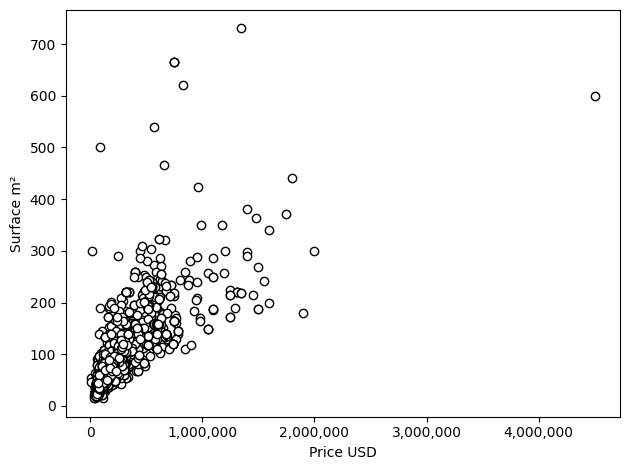

In [281]:
plt.scatter(x=df['DOLARES'], y=df['M2'], edgecolors='black', color='white')
plt.gca().get_xaxis().set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.xlabel('Price USD')
plt.ylabel('Surface m²')
plt.tight_layout()

While plotting scatter plots of `ANTIGUEDAD` (apartment age in years), I found a data point with a value of 2016. It should be 0, as the dataset is from that same year.#%%


In [345]:
sorted(df['ANTIGUEDAD'].unique())[-5:]

[np.int64(95), np.int64(96), np.int64(100), np.int64(110), np.int64(2016)]

In [346]:
df = df[df['ANTIGUEDAD'] != 2016]

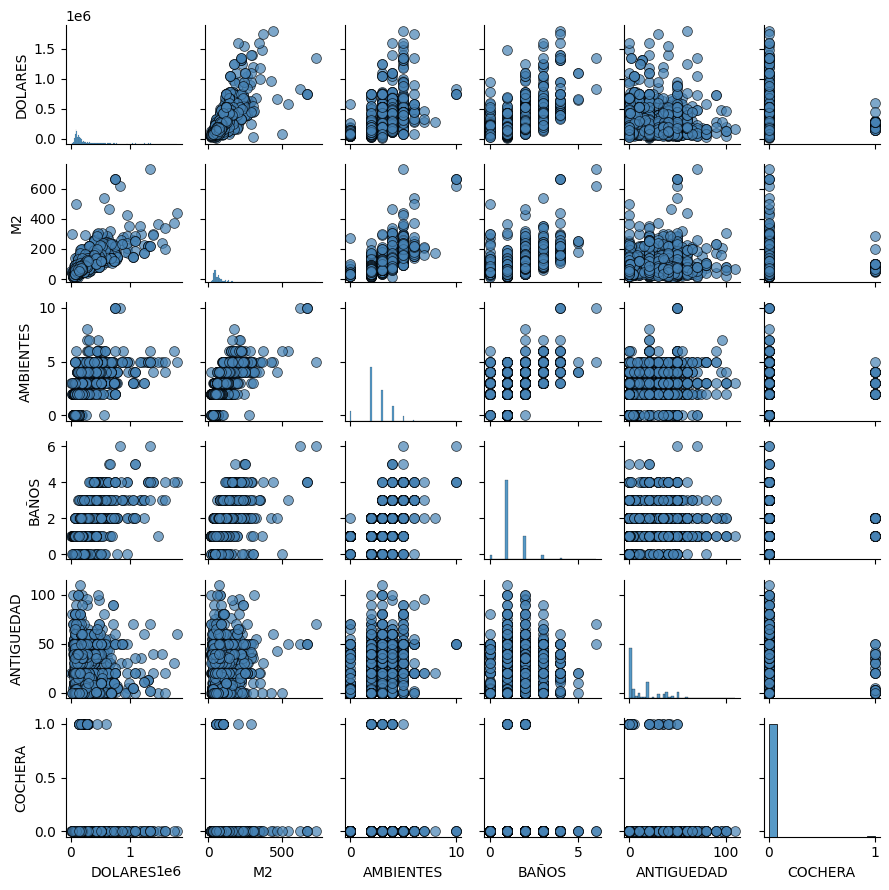

In [347]:
import seaborn as sns

df_scatter = df.drop(['BARRIO', 'CALLE', 'NUMERO'], axis=1)

#plt.figure(figsize=(4, 4))
sns.pairplot(df_scatter, markers='o', plot_kws={'s': 50, 'edgecolor': 'black', 'alpha': 0.7, 'color':'steelblue'},
             height=1.5, aspect=1)
plt.tight_layout()
plt.show()

## Simple Linear Regression

In [348]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [350]:
y = df['DOLARES']
X = df.drop('DOLARES', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

preprocessor = ColumnTransformer(transformers=[
    ('categorical', OneHotEncoder(handle_unknown='ignore'), ['BARRIO', 'CALLE', 'COCHERA', 'AMBIENTES', 'BAÑOS'])],
    # AMBIENTES and BAÑOS as nominally encoded give better model results than ordinally encoded
    remainder='passthrough',
    force_int_remainder_cols=False
)

model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [304]:
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

In [305]:
print(f'Training dataset:\n'
      f'R²: {r2_score(y_train, y_train_pred):.2f}\n'
      f'RMSE: {root_mean_squared_error(y_train, y_train_pred):.2f}\n'
      f'MAE: {mean_absolute_error(y_train, y_train_pred):.2f}\n')

print(f'Test dataset:\n'
      f'R²: {r2_score(y_test, y_test_pred):.2f}\n'
      f'RMSE: {root_mean_squared_error(y_test, y_test_pred):.2f}\n'
      f'MAE: {mean_absolute_error(y_test, y_test_pred):.2f}\n')


Training dataset:
R²: 0.88
RMSE: 54971.98
MAE: 27822.55

Test dataset:
R²: 0.77
RMSE: 90236.66
MAE: 35586.09



There is clearly overfitting.

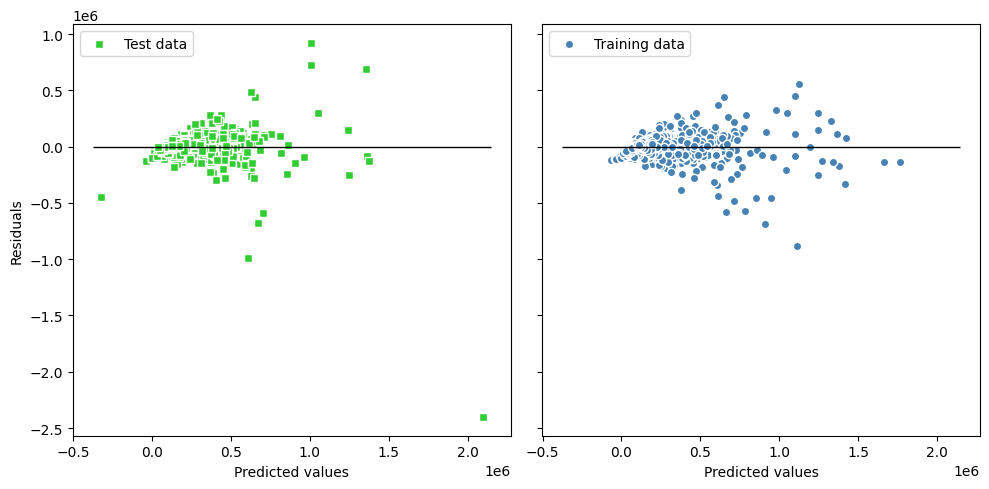

In [306]:
x_min = min(y_test_pred.min(), y_train_pred.min())
x_max = max(y_test_pred.max(), y_train_pred.max())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot residuals for test and training data
ax1.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolor='white', label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolor='white', label='Training data')

ax1.set_ylabel('Residuals')
ax1.set_xlabel('Predicted values')
ax2.set_xlabel('Predicted values')

# horizontal line at y=0 (no residuals)
for ax in (ax1, ax2):
    ax.hlines(y=0, xmin=x_min-50000, xmax=x_max+50000, color='black', lw=1)
    ax.legend(loc='upper left')

plt.tight_layout()

## Regularization methods

In [334]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [364]:
param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 5.0],
    'model__l1_ratio': [0.2, 0.5, 0.8]
}

elastic_pipe = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', ElasticNet(random_state=13, max_iter=10000)) # high max iters for very low alpha values
])

grid_search = GridSearchCV(elastic_pipe, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['BARRIO',
                                                                          'CALLE',
                                                                          'COCHERA',
                                                                          'AMBIENTES',
                                                                          'BAÑOS'])])),
                                       ('model',
                                        ElasticNet(max_iter=10000,
                                                   random_state=13))]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.001, 0.01, 0.1, 1.0, 5.0],
                         'model__l1_ratio': [0.2, 0.5, 0.8]},
             scoring='neg_mean_squared_error', verbose=3)

In [365]:
grid_search.best_params_

{'model__alpha': 0.001, 'model__l1_ratio': 0.5}

In [366]:
best_elastic_pipe = grid_search.best_estimator_

y_train_pred = best_elastic_pipe.predict(X_train)
y_test_pred = best_elastic_pipe.predict(X_test)

print(f'Training dataset:\n'
      f'R²: {r2_score(y_train, y_train_pred):.2f}\n'
      f'RMSE: {root_mean_squared_error(y_train, y_train_pred):.2f}\n'
      f'MAE: {mean_absolute_error(y_train, y_train_pred):.2f}\n')

print(f'Test dataset:\n'
      f'R²: {r2_score(y_test, y_test_pred):.2f}\n'
      f'RMSE: {root_mean_squared_error(y_test, y_test_pred):.2f}\n'
      f'MAE: {mean_absolute_error(y_test, y_test_pred):.2f}\n')

Training dataset:
R²: 0.87
RMSE: 61662.21
MAE: 32108.49

Test dataset:
R²: 0.80
RMSE: 71124.62
MAE: 36488.70



## RANSAC

In [307]:
ransac = RANSACRegressor(LinearRegression(),
                         max_trials=1000,
                         min_samples=.9,
                         residual_threshold=200000,
                         random_state=13,
                         )

model_ransac = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ransac)
])

In [309]:
model_ransac.fit(X_train, y_train)

y_pred = model_ransac.predict(X_test)

print(f'RANSAC results:\n'
      f'R²: {r2_score(y_test, y_pred):.2f}\n'
      f'RMSE: {root_mean_squared_error(y_test, y_pred):.2f}\n'
      f'MAE: {mean_absolute_error(y_test, y_pred):.2f}\n')


RANSAC results:
R²: 0.75
RMSE: 93538.76
MAE: 32775.44

